## Reference

[1] [超簡單台股每日爬蟲教學](https://www.finlab.tw/%E8%B6%85%E7%B0%A1%E5%96%AE%E5%8F%B0%E8%82%A1%E6%AF%8F%E6%97%A5%E7%88%AC%E8%9F%B2%E6%95%99%E5%AD%B8/)

***

# MLE

在這邊，一個簡單的作法便是利用 MLE(最大概似法)來估計我們的參數，最大概似法的想法很簡單，當我們得到一組樣本 $s_1, \cdots, s_n$ 後，

我們想辦法找到參數使的出現這組樣本的機率最大，那這樣的參數便是我們想要的參數。

$$ln(\frac{P_{t}}{P_{t-1}})\sim N(\mu,\sigma^2)$$


$$\hat{\mu} = \frac{\sum^n_{i=1} x_i}{n}  $$$$\hat{\sigma^2} = \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu})^2$$ 我們接下來計算MLE對於常態分配的估計吧


In [2]:
# defination the function

def mle_mu_fun(X):
    n = len(X)
    return sum(X) / n

def mle_sig_fun(X):
    n = len(X)
    mu_hat = mle_mu_fun(X)
    s = sum([(x - mu_hat)**2 for x in X])
    return s/n


In [4]:
print(mle_mu_fun([1,2,3]))
print(mle_sig_fun([1,2,3]))

2.0
0.6666666666666666


# 實際股價資料

In [5]:
# loading library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3


In [6]:

db = sqlite3.connect('TWstock_2')
#台積電2330
tsmc = pd.read_sql(con=db,sql='SELECT * FROM "2330"')

In [7]:
tsmc.index = tsmc['Date']
tsmc.index = pd.to_datetime(tsmc.index)
tsmc = tsmc[['證券名稱','收盤價']]
tsmc['收盤價'] = pd.to_numeric(tsmc['收盤價'].apply(lambda x:x.replace(',','')),errors='coerce')
tsmc.columns = ['stock_code','close']

In [8]:
tsmc.head()

,stock_code,close
Date,,
2019-05-06,台積電,259.0
2019-05-07,台積電,262.5
2019-05-08,台積電,260.0
2019-05-09,台積電,256.5
2019-05-10,台積電,256.0


In [10]:
# 做 週平均：resample('W').mean()
# 並移除 NA 資料
tsmc = tsmc[['close']].resample('W').mean().dropna()

In [15]:
# Calculate the continuous return rate

import math
price_list = list(tsmc['close'])


[258.8, 247.3, 234.6, 231.5, 234.5, 241.3, 241.2, 238.7, 247.125]

In [17]:
print(price_list)
print(price_list[1:])
print(price_list[:-1])

[258.8, 247.3, 234.6, 231.5, 234.5, 241.3, 241.2, 238.7, 247.125]
[247.3, 234.6, 231.5, 234.5, 241.3, 241.2, 238.7, 247.125]
[258.8, 247.3, 234.6, 231.5, 234.5, 241.3, 241.2, 238.7]


In [18]:
# P_{t}/P_{t-1} 
# zip: 兩個可迭代的物件放在一起

ratio_list = [p_1/p_2 for p_1,p_2 in zip(price_list[1:],price_list[:-1])]
print(ratio_list)

[0.955564142194745, 0.9486453699959563, 0.9867860187553282, 1.0129589632829374, 1.028997867803838, 0.9995855781185246, 0.9896351575456053, 1.035295349811479]


In [19]:
# ln(P_{t}/P_{t-1})
c_return_list = [math.log(x) for x in ratio_list]
print(c_return_list)

[-0.04545338809937501, -0.052720238307995486, -0.01330206269308631, 0.012875714360045367, 0.0285853847446521, -0.00041450777795577624, -0.010418931508246002, 0.0346867481459967]


## Estimator the Volatility

In [22]:
# estimate mu and sigma
mu = mle_mu_fun(c_return_list)
sigma_2 = mle_sig_fun(c_return_list)
print(mu)
print(sigma_2)

-0.005770160141995555
0.0008813531991296782


In [26]:
# Graphing

import scipy.stats as stats
import numpy as np

h = sorted(c_return_list)
print(h[0]) # 最小的 return
print(h[-1]) # 最大的 return

-0.052720238307995486
0.0346867481459967


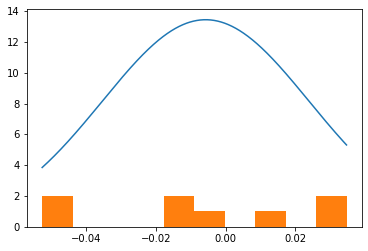

In [27]:
# 在最小與最大的 return 每隔 0.0001 切割一筆資料
x_axis_data = np.arange(h[0],h[-1], 0.0001)

# probability of density function (假設 Normal(mu, sigma_2))
plt.plot(x_axis_data,
         stats.norm.pdf(x_axis_data,mu,math.sqrt(sigma_2)))

# histogram
plt.hist(h) # 實際分配

plt.show()


In [25]:
# 估計週報酬 < -0.04 的機率(CDF)吧
print(stats.norm(mu, math.sqrt(sigma_2)).cdf(-0.04))
# 估計週報酬 > 0.06 的機率(CDF)
print(1 - stats.norm(mu, math.sqrt(sigma_2)).cdf(0.06))

0.12445488309939479
0.013366003647750868
